In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
ls

gdrive/  sample_data/


In [3]:
cd gdrive/

/content/gdrive


In [6]:
ls

MyDrive/


In [4]:
cd MyDrive/

/content/gdrive/MyDrive


In [16]:
from scipy.io import loadmat
total_X = loadmat('rot-mnist-3s.mat')['X'].squeeze() # (N, 16, 784)

In [17]:
total_X.shape

(1042, 16, 784)

In [18]:
from matplotlib import rc
rc('animation', html='jshtml')

In [19]:
from math import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.animation as animation

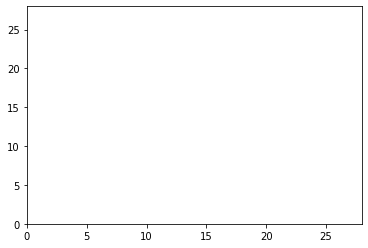

In [20]:
fig = plt.figure() 
ax = plt.axes(xlim=(0, 28), ylim=(0, 28)) 

In [21]:
def frame(w):
 # print(w)

  #ax.clear()
  pixels = total_X[1000,w,:].reshape((28, 28))
  plot=ax.imshow(pixels, cmap='gray')
  w=w+1
    #global x,y,z
    #x=x+np.random.normal(loc=0.0,scale=50.0,size=10)
    #y=y+np.random.normal(loc=0.0,scale=50.0,size=10)
    #z=z+np.random.normal(loc=0.0,scale=50.0,size=10)



    
  return plot

In [22]:
anim = animation.FuncAnimation(fig, frame, frames=15, blit=False, repeat=True)

In [23]:
anim

In [24]:
pip install torchdiffeq


In [89]:
import os
import argparse
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
import torch.nn.functional as F

parser = argparse.ArgumentParser('ODE demo')
parser.add_argument('--method', type=str, choices=['dopri5', 'adams'], default='dopri5')
parser.add_argument('--data_size', type=int, default=1000)
parser.add_argument('--nepochs', type=int, default=20)
parser.add_argument('--batch_time', type=int, default=10)
parser.add_argument('--batch_size', type=int, default=20)
parser.add_argument('--niters', type=int, default=2000)
parser.add_argument('--test_freq', type=int, default=20)
parser.add_argument('--viz', action='store_true')
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('--l_rate', type=float, default=1e-3)
parser.add_argument('--adjoint', action='store_true',default=True)
args = parser.parse_args(args=[])

In [27]:
if args.adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')

In [189]:
class Dataset(data.Dataset):
    def __init__(self, Xtr):
        self.Xtr = Xtr # N,16,784
    def __len__(self):
        return len(self.Xtr)
    def __getitem__(self, idx):
        return self.Xtr[idx]
# read data
X= loadmat('rot-mnist-3s.mat')['X'].squeeze() # (N, 16, 784)
N = 500
T = 16
Xtr   = torch.tensor(X[:N],dtype=torch.float32).view([N,T,1,28,28])
Xtest = torch.tensor(X[N:],dtype=torch.float32).view([-1,T,1,28,28])
#Xtr   = torch.tensor(X[:N],dtype=torch.float32)
#Xtest = torch.tensor(X[N:],dtype=torch.float32)
# Generators
params = {'batch_size': args.batch_size, 'shuffle': True, 'num_workers': 2}
trainset = Dataset(Xtr)
trainset = data.DataLoader(trainset, **params)
testset  = Dataset(Xtest)
testset  = data.DataLoader(testset, **params)


In [190]:
Xtr.shape

torch.Size([500, 16, 1, 28, 28])

In [137]:
class ODEFunc(nn.Module):
  def __init__(self):
        # call constructor from superclass
        super().__init__()
        
        # define network layers
        self.fc1 = nn.Linear(784, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, 100)
        self.fc5 = nn.Linear(100, 784)
        
  def forward(self,t, x):
        # define forward pass
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.tanh(self.fc3(x))
        x = F.tanh(self.fc4(x))
        x = F.tanh(self.fc5(x))
        return x



In [229]:
class ODEFunc2(nn.Module):
    def __init__(self):
        super(ODEFunc2, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 784)

    def forward(self,t,x):

        #print(x.shape)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        #print(x.shape)
        return torch.tensor(x).view([args.batch_size,1,28,28])
  


In [230]:
ODEFunc2()


ODEFunc2(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=784, bias=True)
)

In [236]:
if __name__ == '__main__':

  func = ODEFunc2().to(device)
  optimizer = torch.optim.Adam(func.parameters(),lr=args.l_rate)
  t = torch.linspace(0., 1.,minibatch.shape[1]).to(device)
  for epoch in range(args.nepochs):
    for i,local_batch in enumerate(trainset):
      print('Here1')
      optimizer.zero_grad()
      minibatch = local_batch.to(device)
      batch_y0=minibatch[:,0,:].to(device)
      batch_t=t
      pred_y = odeint(func, batch_y0, torch.tensor(batch_t)).to(device)
      pred_y=pred_y.swapaxes(0,1).to(device)
      loss = torch.mean(torch.abs(pred_y - minibatch))
      loss.backward()
      optimizer.step()
      print('Here2')
    

    with torch.no_grad():
      true_y0=Xtest[:,0,:].to(device)
      pred_y = odeint(func, true_y0, t).to(device)
      pred_y=pred_y.swapaxes(0,1).to(device)
      loss=nn.MSELoss()

      print('Epoch {:04d} | Total Loss {:.6f}'.format(epoch, loss(pred_y,Xtest.to(device))))
               




  


Here1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


KeyboardInterrupt: ignored

In [154]:
true_y0=Xtest[10,0,:].to(device)
pred_y = odeint(func, true_y0, t).to(device)
pred_y=pred_y.cpu().detach().numpy()
#pred_y=pred_y.swapaxes(0,1).to(device)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [155]:
pred_y.shape

(16, 784)

In [156]:
def frame(w):
 # print(w)

  #ax.clear()
  pixels = pred_y[w,:].reshape((28, 28))
  plot=ax.imshow(pixels, cmap='gray')
  w=w+1
    #global x,y,z
    #x=x+np.random.normal(loc=0.0,scale=50.0,size=10)
    #y=y+np.random.normal(loc=0.0,scale=50.0,size=10)
    #z=z+np.random.normal(loc=0.0,scale=50.0,size=10)



    
  return plot

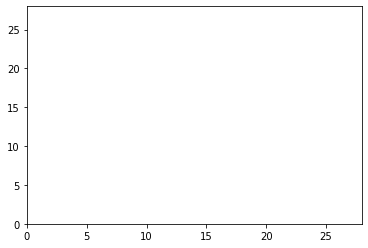

In [157]:
fig = plt.figure() 
ax = plt.axes(xlim=(0, 28), ylim=(0, 28)) 

In [158]:
anim = animation.FuncAnimation(fig, frame, frames=15, blit=False, repeat=True)
anim

In [192]:
minibatch.shape

torch.Size([20, 16, 1, 28, 28])

In [193]:
batch_y0.shape

torch.Size([20, 1, 28, 28])

In [194]:
batch_t

tensor([0.0000, 0.0667, 0.1333, 0.2000, 0.2667, 0.3333, 0.4000, 0.4667, 0.5333,
        0.6000, 0.6667, 0.7333, 0.8000, 0.8667, 0.9333, 1.0000],
       device='cuda:0')

In [141]:
pred_y.shape

torch.Size([542, 16, 784])

In [142]:
Xtest.to(device).shape

torch.Size([542, 16, 784])

In [145]:
loss=nn.MSELoss()

In [147]:
loss(pred_y,Xtest.to(device))

tensor(0.0945, device='cuda:0')

AttributeError: ignored

In [164]:
minibatch.shape

torch.Size([20, 16, 784])

In [167]:
min_new= torch.tensor(minibatch).view([20,16,1,28,28])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [168]:
minibatch.shape

torch.Size([20, 16, 784])

In [179]:
a=torch.ones((3,3))

In [180]:
a

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])

In [185]:
b=torch.zeros((3,3))
b[0,0]=1
b

tensor([[1., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [186]:
loss=nn.MSELoss()
loss(a,b)

tensor(0.8889)

In [188]:
8/9

0.8888888888888888

In [198]:
a=torch.arange(10)

In [199]:
a

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [200]:
a.reshape((2,5))

tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]])

In [208]:
784*20

15680

In [211]:
batch_y0.shape

torch.Size([20, 1, 28, 28])

In [212]:
minibatch.shape

torch.Size([20, 16, 1, 28, 28])

In [222]:
func = ODEFunc2().to(device)
func(batch_y0).shape

torch.Size([20, 784])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([20, 1, 28, 28])

In [239]:
minibatch.shape

torch.Size([20, 16, 1, 28, 28])

In [237]:
batch_y0.shape

torch.Size([20, 1, 28, 28])

In [238]:
Xtest.shape

torch.Size([542, 16, 1, 28, 28])